Vanilla GAN from this website

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/VanillaGAN.ipynb

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb


Combine into a DCGAN - 1D

https://github.com/LixiangHan/GANs-for-1D-Signal/blob/main/dcgan.py



In [1]:
!pip install torch torchvision


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import time


In [4]:
!pip install torchinfo
from torchinfo import summary


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import datetime
import os, sys
import scipy.io

In [6]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [7]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def to_onehot(x, num_classes=2):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [9]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    #img = np.zeros([280, 280])
    for j in range(2):
        c = torch.zeros([10, 2]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE) # number of random noise vectors created = 10
        y_hat = G(z,c).view(10, 3, 1000) #(10, 3, 1000)
        #result = y_hat.cpu().data.numpy()
        if j == 0: # this is a left movement
          data_left = y_hat.cpu().data.numpy()
        else:
          data_right = y_hat.cpu().data.numpy()
    return data_left, data_right

In [10]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=3000, condition_size=2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 2048),
#            nn.LeakyReLU(0.2),
#            nn.Linear(4096, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x, c):

        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        return y_

In [11]:

# Define model and inputs
#model = Discriminator(input_size=3000, condition_size=2, num_classes = 1) # is num_classes teh number of classifications?
#batch_size = 16
#input_size = (batch_size, 3, 1000)  # Adjust based on your use case
#class_label_size = (batch_size, 2)

# Summarize model
#summary(
#    model,
#    input_size=(input_size, class_label_size),
#    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
#    depth=3
#)

In [12]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=2, num_classes=3000): # flag for later, should this be
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            #nn.Linear(512, 1024),
            #nn.BatchNorm1d(1024),
            #nn.LeakyReLU(0.2),
           # nn.Linear(1024, 2048),
           # nn.BatchNorm1d(2048),
           # nn.LeakyReLU(0.2),
           # nn.Linear(2048, 4096),
           # nn.BatchNorm1d(4096),
           # nn.LeakyReLU(0.2),
            nn.Linear(512, num_classes),
            nn.Tanh()
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 3, 1000)
        return y_

In [13]:
# Define model and inputs
#model = Generator(input_size=100, condition_size=2)
#batch_size = 16
#input_size = (batch_size, 100)  # Adjust based on your use case
#class_label_size = (batch_size, 2)

# Summarize model
#summary(
#    model,
#    input_size=(input_size, class_label_size),
#    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
#    depth=3
#)

In [14]:
n_noise = 100

In [15]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [16]:
#data =  np.empty((1000, 3, 3240)) # empty np array that concatenates all of the trials
#labels = [] #np.empty((3240,1))
list_of_files = ['B0901T.mat', 'B0902T.mat', 'B0903T.mat', 'B0801T.mat', 'B0802T.mat', 'B0803T.mat','B0701T.mat', 'B0702T.mat', 'B0703T.mat',
                 'B0601T.mat', 'B0602T.mat', 'B0603T.mat', 'B0501T.mat', 'B0502T.mat', 'B0503T.mat', 'B0401T.mat', 'B0402T.mat', 'B0403T.mat',
                 'B0301T.mat', 'B0302T.mat', 'B0303T.mat', 'B0201T.mat', 'B0202T.mat', 'B0203T.mat', 'B0101T.mat', 'B0102T.mat', 'B0103T.mat']

#for idx in range(len(list_of_files)):
#  target_tmp = scipy.io.loadmat(list_of_files[idx])
#  data_tmp = target_tmp['data']
#  label_tmp = target_tmp['label']
#  data[:,:, idx*120:(idx+1)*120] = data_tmp
#  for i in range(len(label_tmp)):
#    if label_tmp[i] == 1.0:
##      labels.append(0)
 #   else:
 #     labels.append(1)
        
#left = [0,0,:] 
#right = [1,0,:]

#data = np.transpose(data, (2, 1, 0))  
#label = np.array(labels).reshape(3240, 1)


In [17]:
data =  [] # empty np array that concatenates all of the trials
labels = [] #np.empty((3240,1))
temps= []
target_tmp = scipy.io.loadmat(list_of_files[0])
data_tmp = target_tmp['data']
label_tmp = target_tmp['label']

constant_right = data_tmp[:, 0, 0]
constant_left = data_tmp[:, 0, 1]
for i in range(3240): 
    indicator = np.random.randint(0,2)
    for j in range(3): 
        if indicator == 0: #left movement 
            temps.append(constant_left)
            if j == 0: 
                labels.append(0)
        else: 
            temps.append(constant_right)
            if j ==0: 
                labels.append(1)
            
#left = [0,0,:] 
#right = [1,0,:]

data = np.array(temps).reshape(3240,3,1000) 
label = np.array(labels).reshape(3240, 1)



In [18]:
# normalize the data to be between [0, 1]
mins = []
maxes = []

for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    mins.append(np.min(data[i, j, :]))
    maxes.append(np.max(data[i, j, :]))
max_data = np.average(maxes)
min_data = np.average(mins)
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    data[i, j, :] = (data[i, j, :] - min_data) / (max_data - min_data)

In [19]:
class Sine_Cosine_Dataset(Dataset):
  def __init__(self, data, labels, transform=None):
    self.data = data
    self.labels = labels
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data = self.data[index]
    label = self.labels[index]

    if self.transform:
      data = self.transform(data)

    return data, label

In [20]:
dataset = Sine_Cosine_Dataset(data, labels)

In [21]:
batch_size = 512
condition_size=2

In [22]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [23]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.00035, betas=(0.5, 0.999))

In [24]:
max_epoch = 2000 # need more than 10 epochs for training generator
step = 0
n_critic = 2 # for training more k steps about Discriminator

In [25]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [26]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [27]:
start_time = time.time()
Discriminator_loss = []
Generator_loss = []
steps = []
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE).float()
        y = labels.view(batch_size, 1).long()
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        
            
        step += 1
    print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
    Discriminator_loss.append(D_loss.item())
    Generator_loss.append(G_loss.item())
        
end_time = time.time()
elapsed_time = end_time - start_time 
print(f"Computation Time : {elapsed_time}")
        #if step % 1000 == 0:
           # G.eval()
            #img = get_sample_image(G, n_noise)
            #imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            #G.train()

        #step += 1

Epoch: 0/2000, Step: 6, D Loss: 0.5390223860740662, G Loss: 1.0157206058502197
Epoch: 1/2000, Step: 12, D Loss: 0.12769484519958496, G Loss: 4.369925022125244
Epoch: 2/2000, Step: 18, D Loss: 0.61954665184021, G Loss: 3.926793098449707
Epoch: 3/2000, Step: 24, D Loss: 0.20832185447216034, G Loss: 6.930987358093262
Epoch: 4/2000, Step: 30, D Loss: 0.7824068665504456, G Loss: 0.643803060054779
Epoch: 5/2000, Step: 36, D Loss: 0.4673621356487274, G Loss: 1.062241554260254
Epoch: 6/2000, Step: 42, D Loss: 0.1113448366522789, G Loss: 2.8632636070251465
Epoch: 7/2000, Step: 48, D Loss: 0.28492066264152527, G Loss: 3.1635520458221436
Epoch: 8/2000, Step: 54, D Loss: 2.653184175491333, G Loss: 0.11947085708379745
Epoch: 9/2000, Step: 60, D Loss: 1.0537632703781128, G Loss: 0.6006482243537903
Epoch: 10/2000, Step: 66, D Loss: 0.9264261722564697, G Loss: 0.6245569586753845
Epoch: 11/2000, Step: 72, D Loss: 0.7247385382652283, G Loss: 0.8017417192459106
Epoch: 12/2000, Step: 78, D Loss: 0.5060721

<function matplotlib.pyplot.show(close=None, block=None)>

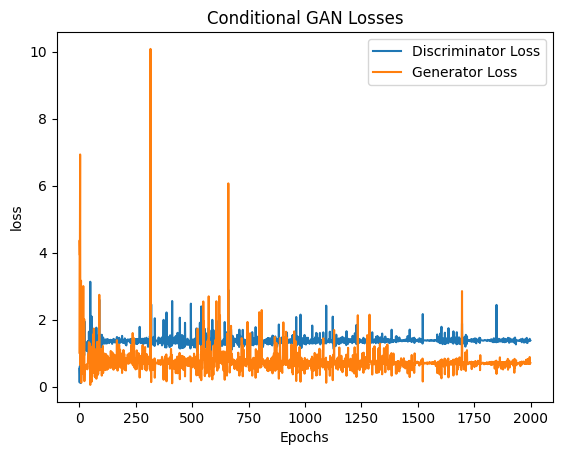

In [28]:
import matplotlib.pyplot as plt
#print(steps)
plt.plot(Discriminator_loss)
plt.plot(Generator_loss)
plt.title('Conditional GAN Losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show

In [29]:
G.eval()
data_left, data_right = get_sample_image(G, n_noise)
x = np.linspace(0, 4, num=1000)

In [30]:
#choose right and left
stop_button = 0
while stop_button < 3: 
    for i in label:
        if i == 0: 
            y_left = data[i, 0,:].squeeze()
            stop_button +=1
        else: 
            y_right = data[i,0,:].squeeze()
            stop_button +=1

<function matplotlib.pyplot.show(close=None, block=None)>

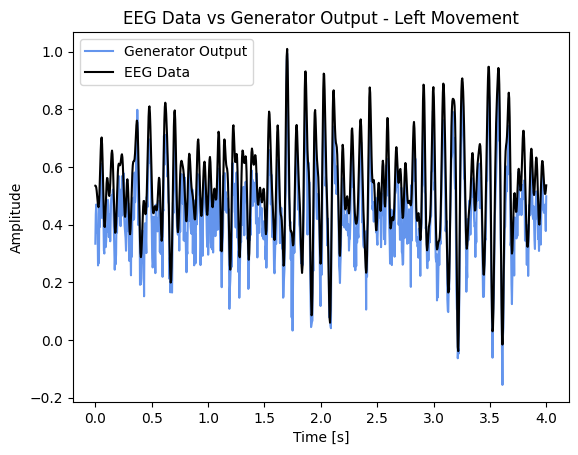

In [31]:
#This is for the Left
# (trials, channels, ms of data ) #3240, 3, 1000


plt.plot(x, data_left[9,1,:], label='Generator Output', color='cornflowerblue')
plt.plot(x, y_left, label = 'EEG Data', color='black')
plt.ylabel('Amplitude')
plt.title('EEG Data vs Generator Output - Left Movement')
plt.xlabel('Time [s]')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

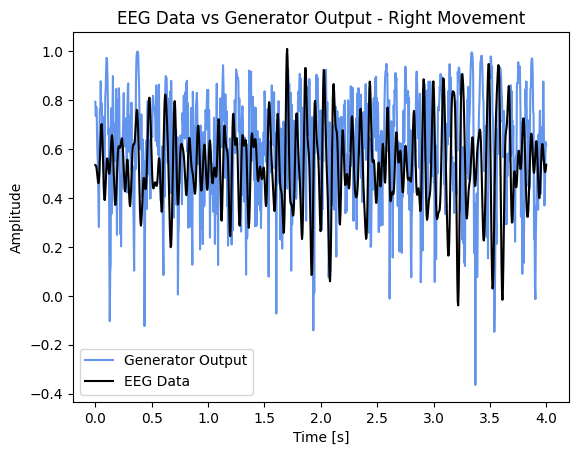

In [32]:
#This is for The right

plt.plot(x, data_right[9,1,:], label='Generator Output', color='cornflowerblue')
plt.plot(x, y_right, label='EEG Data', color='black')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.title('EEG Data vs Generator Output - Right Movement')
plt.legend()
plt.show